# Hyperparameter Tuning

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Load Dataset

In [11]:
df = pd.read_csv('../data/processed_data_with_anomaly.csv')

## Definisi Fitur dan Target

In [12]:
features = ['Lag_1_Status', 'Count_Telat_7D', 'Count_Alpa_30D', 'Streak_Telat', 'Avg_Arrival_Time_7D', 'DayOfWeek']
le = LabelEncoder()

X = df[features]
# Encode 'Lag_1_Status' in the features
X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))

y = le.fit_transform(df['note'].astype(str))

/tmp/ipykernel_111643/870299856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Lag_1_Status'] = le.fit_transform(X['Lag_1_Status'].astype(str))


## Split Data

In [13]:
# 80% train-test split

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Data Latih: {X_train.shape[0]} baris")
print(f"Data Uji: {X_test.shape[0]} baris")

Data Latih: 101904 baris
Data Uji: 25476 baris


In [14]:
# Define hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [25, 50, 75, 100], 
            'criterion': ['gini', 'entropy'], 
            'min_samples_split': [2, 4, 8], 
            'min_samples_leaf': [10, 15, 20]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [20, 30, 50], 
            'max_depth': [3, 4, 7, 9], 
            'min_samples_split': [2, 5, 8], 
            'max_features' : [2, 3, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='mlogloss', random_state=42),
        'params': {
            'learning_rate': [0.1, 0.15, 0.2], 
            'max_depth': [3, 5, 10], 
            'gamma' : [1, 2, 3],
            'reg_alpha' :[20, 30, 40], 
            'reg_lambda' :[0, 1],
            'colsample_bytree' :[0.5, 0.7, 1],
            'min_child_weight' :[0, 1, 2],
            'n_estimators' :[180], 
            'seed' :[0]
        },
    },
    'Gaussian NB': {
        'model': Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', GaussianNB())
        ]),
        'params': {
            'clf__var_smoothing': [1e-9, 1e-7, 1.0, 1.2, 1.4]
        }
    },
    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', SVC(random_state=42))
        ]),
        'params': {
            'clf__C': [1, 3, 5, 7], 
            'clf__kernel': ['linear', 'rbf'], 
            'clf__gamma': ['scale', 'auto']
        }
    }
}

In [15]:
best_params = {}

# TimeSeriesSplit untuk Cross Validation (agar tidak bocor waktu)
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
for name, config in param_grids.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=tscv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params[name] = grid.best_estimator_
    print(f"  Best Params: {grid.best_params_}")
    print(f"  Best CV Score: {grid.best_score_:.4f}")

Tuning Decision Tree...
  Best Params: {'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 2}
  Best CV Score: 0.4383
Tuning Random Forest...
  Best Params: {'max_depth': 7, 'max_features': 3, 'min_samples_split': 5, 'n_estimators': 50}
  Best CV Score: 0.4689
Tuning XGBoost...
  Best Params: {'colsample_bytree': 0.5, 'gamma': 2, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 0, 'n_estimators': 180, 'reg_alpha': 20, 'reg_lambda': 1, 'seed': 0}
  Best CV Score: 0.4665
Tuning Gaussian NB...
  Best Params: {'clf__var_smoothing': 1e-09}
  Best CV Score: 0.5036
Tuning SVM...
  Best Params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
  Best CV Score: 0.4580


## Compare Models


Evaluating Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.75      0.58      0.66     16819
           1       0.41      0.66      0.51      7735
           2       0.06      0.01      0.02       922

    accuracy                           0.59     25476
   macro avg       0.41      0.42      0.40     25476
weighted avg       0.63      0.59      0.59     25476


Confusion Matrix for Decision Tree:


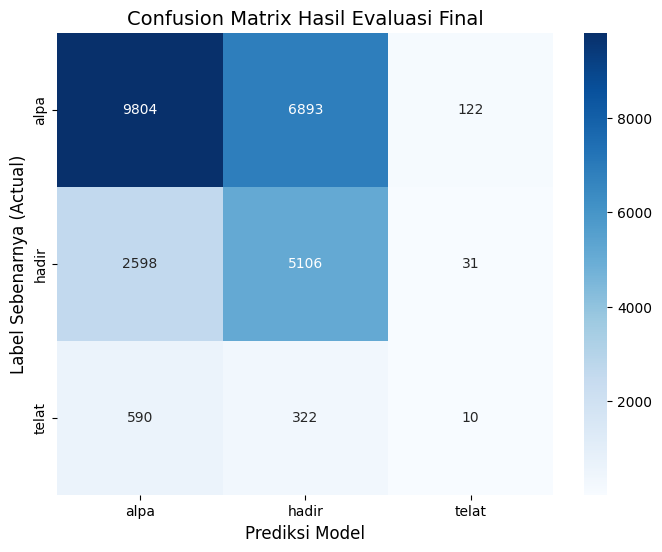


Evaluating Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     16819
           1       0.44      0.72      0.55      7735
           2       0.06      0.00      0.00       922

    accuracy                           0.62     25476
   macro avg       0.43      0.44      0.41     25476
weighted avg       0.66      0.62      0.62     25476


Confusion Matrix for Random Forest:


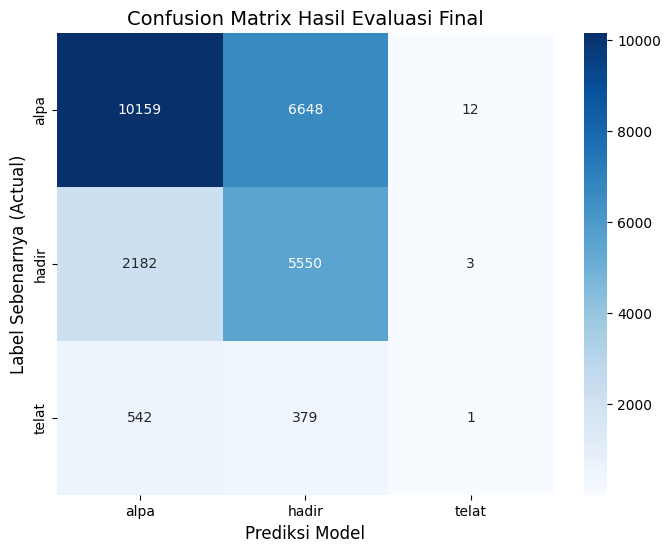


Evaluating XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.57      0.66     16819
           1       0.42      0.72      0.53      7735
           2       0.05      0.00      0.00       922

    accuracy                           0.60     25476
   macro avg       0.42      0.43      0.40     25476
weighted avg       0.64      0.60      0.60     25476


Confusion Matrix for XGBoost:


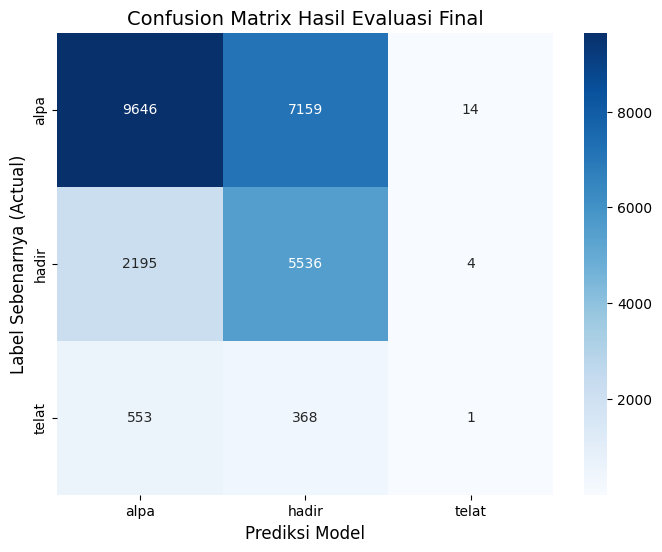


Evaluating Gaussian NB...

Classification Report for Gaussian NB:
              precision    recall  f1-score   support

           0       0.75      0.39      0.51     16819
           1       0.37      0.76      0.50      7735
           2       0.10      0.09      0.10       922

    accuracy                           0.49     25476
   macro avg       0.41      0.41      0.37     25476
weighted avg       0.61      0.49      0.49     25476


Confusion Matrix for Gaussian NB:


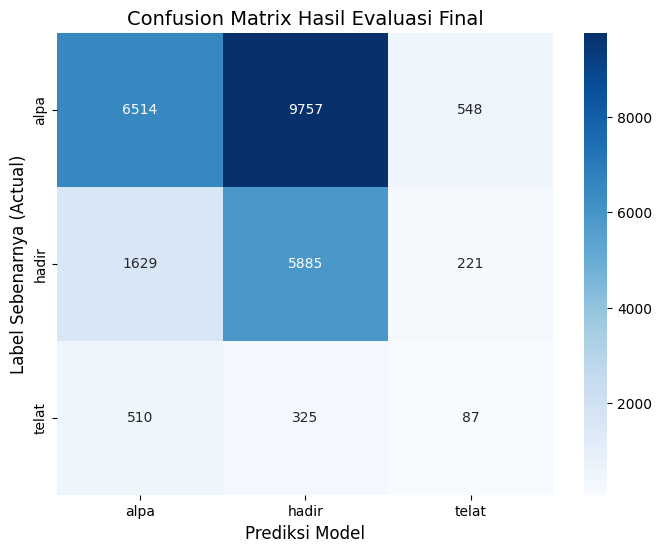


Evaluating SVM...

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.78      0.60      0.68     16819
           1       0.44      0.71      0.54      7735
           2       0.17      0.00      0.01       922

    accuracy                           0.61     25476
   macro avg       0.46      0.44      0.41     25476
weighted avg       0.66      0.61      0.61     25476


Confusion Matrix for SVM:


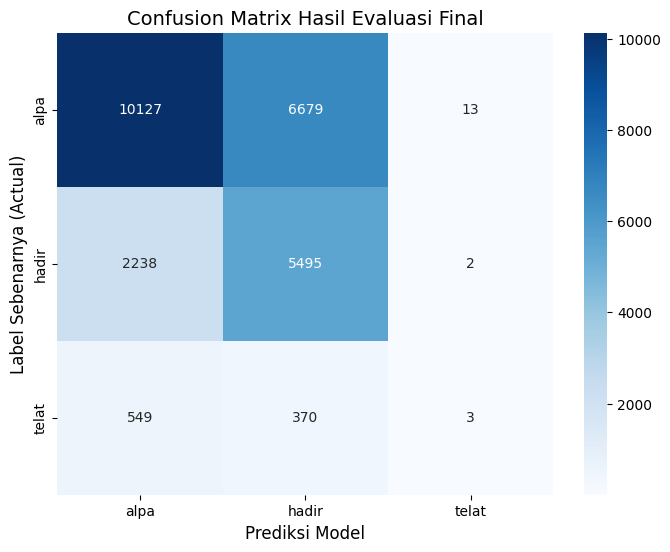

In [25]:
results = []

for name, model in best_params.items():
  print(f"\n{'='*50}")
  print(f"Evaluating {name}...")
  print('='*50)
  
  # Make predictions
  y_pred = model.predict(X_test)
  
  # Calculate metrics
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  
  # Store results
  results.append({
    'Model': name,
    'Recall (macro)': recall,
    'F1-Score (macro)': f1
  })
  
  # Print classification report
  print(f"\nClassification Report for {name}:")
  print(classification_report(y_test, y_pred))
  
  # Print confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print(f"\nConfusion Matrix for {name}:")

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.xlabel('Prediksi Model', fontsize=12)
  plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
  plt.title('Confusion Matrix Hasil Evaluasi Final', fontsize=14)
  plt.show()

In [26]:
# Create comparison dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score (macro)', ascending=False)
print(f"\n{'='*50}")
print("MODEL COMPARISON SUMMARY")
print('='*50)
print(results_df.to_string(index=False))


MODEL COMPARISON SUMMARY
        Model  Recall (macro)  F1-Score (macro)
Random Forest        0.440874          0.410890
          SVM        0.438593          0.409840
      XGBoost        0.430103          0.398292
Decision Tree        0.417958          0.395117
  Gaussian NB        0.414163          0.368636


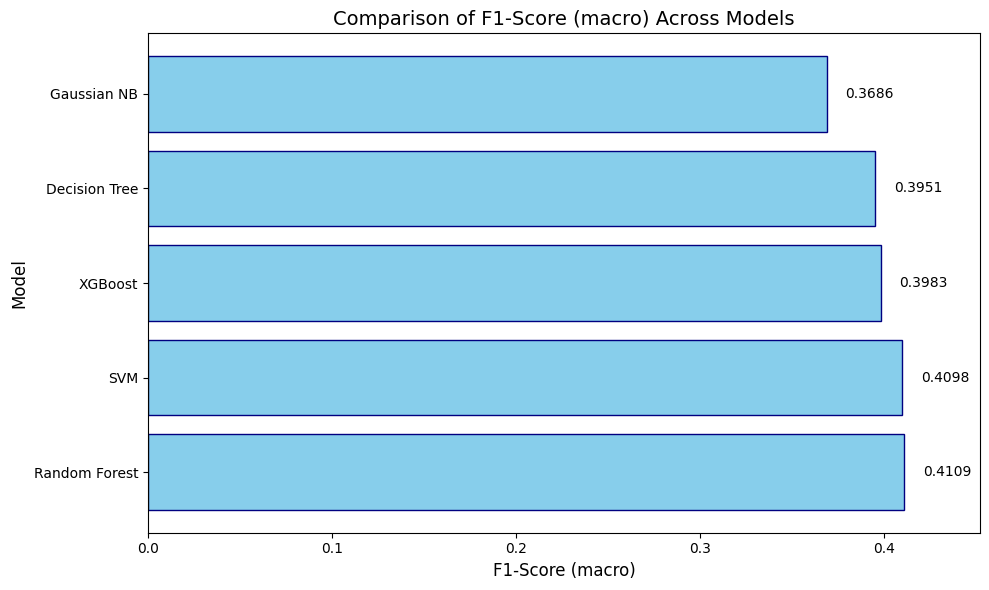

In [27]:
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['F1-Score (macro)'], color='skyblue', edgecolor='navy')
plt.xlabel('F1-Score (macro)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Comparison of F1-Score (macro) Across Models', fontsize=14)
plt.xlim(0, max(results_df['F1-Score (macro)']) * 1.1)

# Add value labels on bars
for i, (model, score) in enumerate(zip(results_df['Model'], results_df['F1-Score (macro)'])):
  plt.text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()